In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility


In [149]:
df = pd.read_csv('C:\\Users\\KIIT\\Downloads\\heart_disease_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [150]:
means = df.mean(numeric_only=True)  # Use numeric_only=True 
print(means)

age          54.366337
sex           0.683168
cp            0.966997
trestbps    131.623762
chol        246.264026
fbs           0.148515
restecg       0.528053
thalach     149.646865
exang         0.326733
oldpeak       1.039604
slope         1.399340
ca            0.729373
thal          2.313531
target        0.544554
dtype: float64


In [151]:
medians = df.median(numeric_only=True)  # Use numeric_only=True 
print(medians)

age          55.0
sex           1.0
cp            1.0
trestbps    130.0
chol        240.0
fbs           0.0
restecg       1.0
thalach     153.0
exang         0.0
oldpeak       0.8
slope         1.0
ca            0.0
thal          2.0
target        1.0
dtype: float64


In [152]:
modes = df.mode(dropna=True)  # dropna=True ignores rows with any NaN
print(modes)

    age  sex   cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0  58.0  1.0  0.0     120.0   197  0.0      1.0    162.0    0.0      0.0   
1   NaN  NaN  NaN       NaN   204  NaN      NaN      NaN    NaN      NaN   
2   NaN  NaN  NaN       NaN   234  NaN      NaN      NaN    NaN      NaN   

   slope   ca  thal  target  
0    2.0  0.0   2.0     1.0  
1    NaN  NaN   NaN     NaN  
2    NaN  NaN   NaN     NaN  


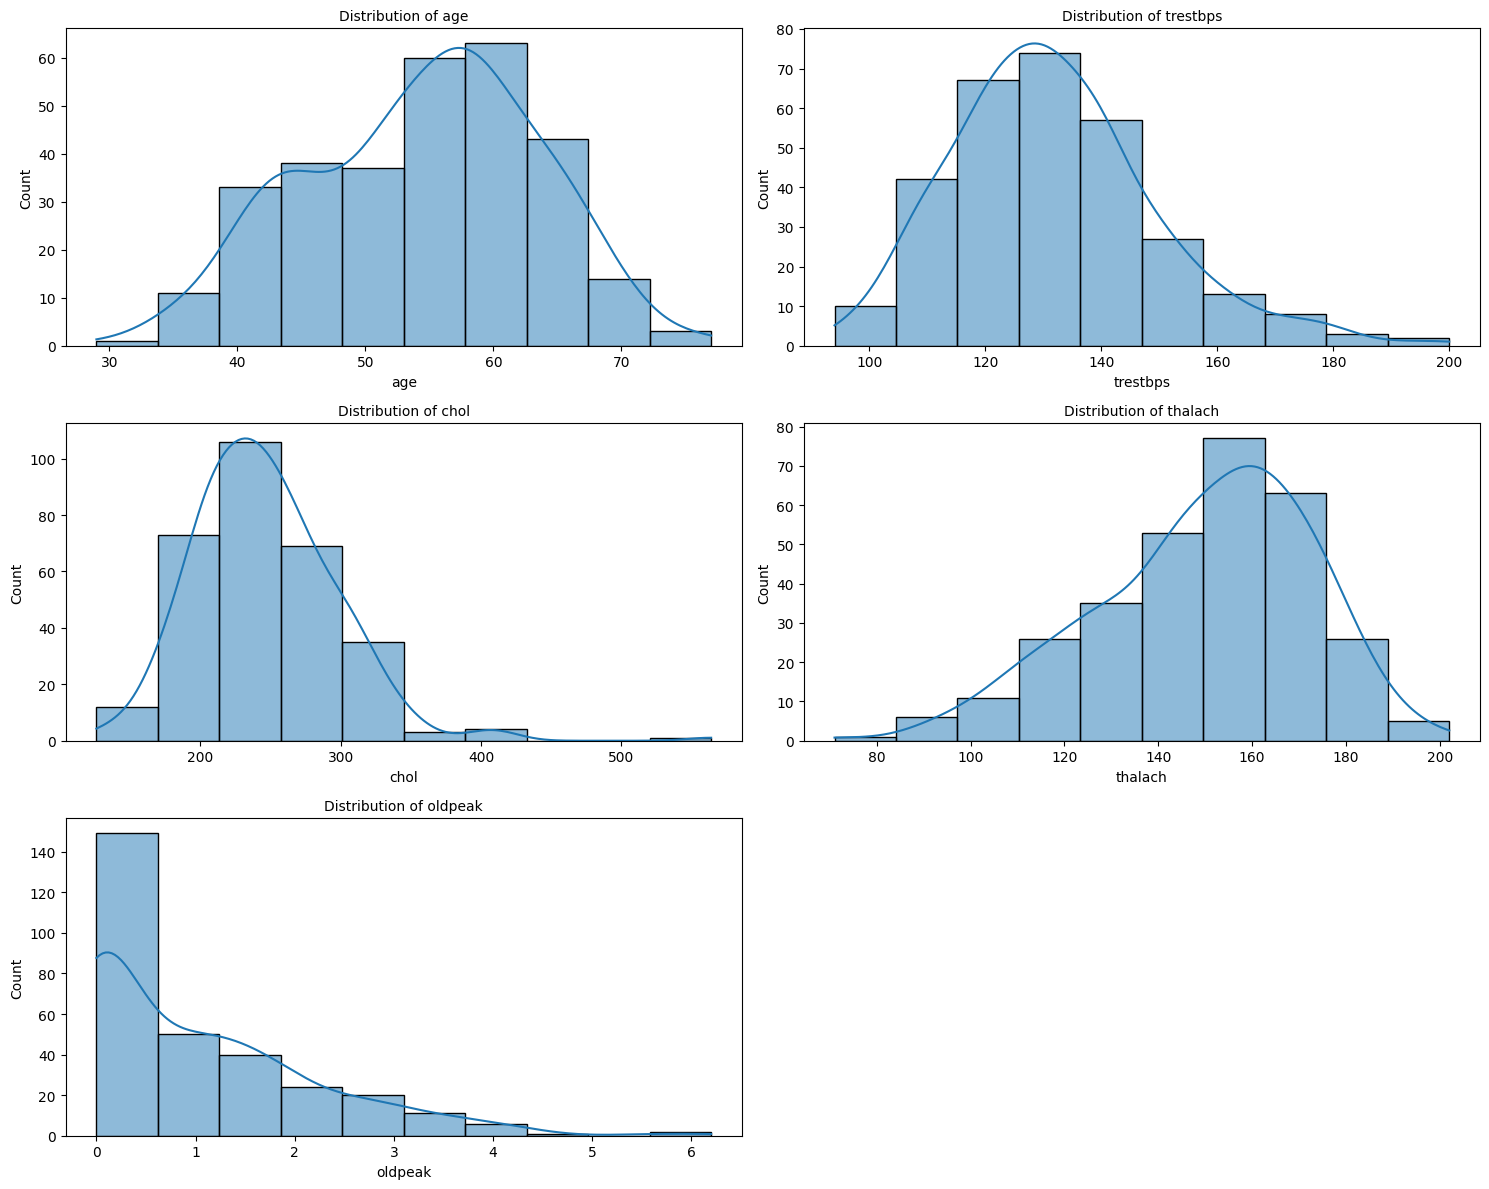

In [153]:
# Create histograms for numerical features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
plt.figure(figsize=(15, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[feature], kde=True, bins=10)
    plt.title(f'Distribution of {feature}', fontsize=10)
plt.tight_layout()
plt.show()

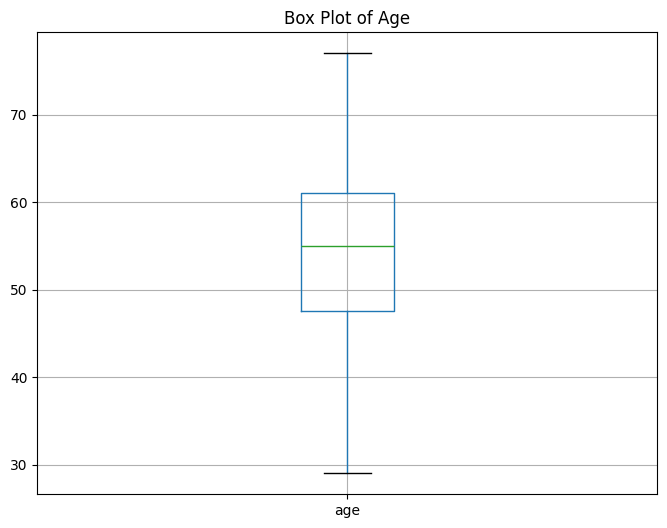

In [154]:
plt.figure(figsize=(8, 6))
df.boxplot(column='age', ax=plt.gca())
plt.title('Box Plot of Age')
plt.show()


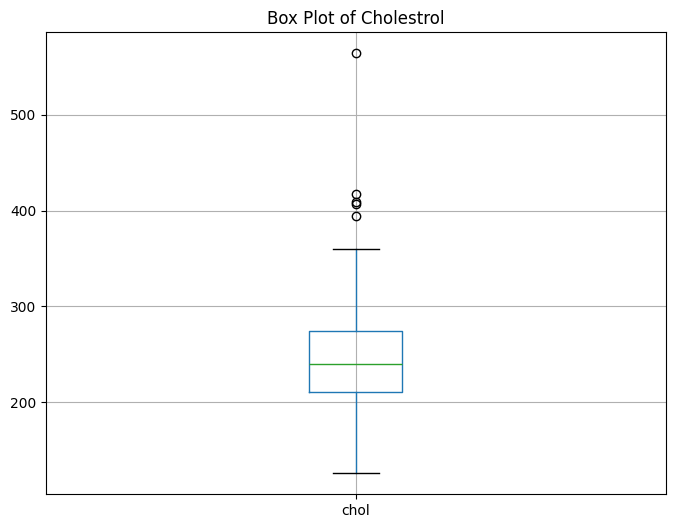

In [155]:
plt.figure(figsize=(8, 6))
df.boxplot(column='chol', ax=plt.gca())
plt.title('Box Plot of Cholestrol')
plt.show()
  

In [156]:
corr_matrix = df.corr()
#extract correlations with target
target_corr = corr_matrix["target"]  
#take absolute values and sort descending
abs_target_corr = target_corr.abs().sort_values(ascending=False)
print(abs_target_corr)
  

target      1.000000
exang       0.436757
cp          0.433798
oldpeak     0.430696
thalach     0.421741
ca          0.391724
slope       0.345877
thal        0.344029
sex         0.280937
age         0.225439
trestbps    0.144931
restecg     0.137230
chol        0.085239
fbs         0.028046
Name: target, dtype: float64


Correlations with Target (absolute values, sorted descending):
Strongest: oldpeak (0.43, negative correlation—higher depression linked to disease)

ca (0.40, number of major vessels)

thal (0.36, thalassemia type)

cp (0.35, chest pain type).

Moderate: thalach (0.42, inverse—lower max HR linked to disease)

exang (0.44, exercise-induced angina).

Weak/Negligible: age (0.22)

fbs (0.028, fasting blood sugar).

In [157]:
# Value counts with proportions
targetcount = df['target'].value_counts()
targetpercentage = df['target'].value_counts(normalize=True)*100 #representation of percentage value

# Combine into a summary DataFrame
balance = pd.DataFrame({
    'Count': targetcount,
    'Percentage': targetpercentage.round(2)
}).sort_index()

print("Class Balance Summary:\n", balance)

# Imbalance ratio (majority / minority)
imbalanceratio = targetcount.max() / targetcount.min()
print(f"\nImbalance Ratio (Majority/Minority): {imbalanceratio:.2f}")


Class Balance Summary:
         Count  Percentage
target                   
0         138       45.54
1         165       54.46

Imbalance Ratio (Majority/Minority): 1.20


Mild Imbalance

A 1.20 ratio is relatively balanced compared to severe cases (e.g., 10:1 in fraud detection). The classes are close (54.5% vs. 45.5%), so models won't heavily bias toward the majority without intervention. The pie chart in the code visually confirms this near-even split.

Percentage of patient without heart problems: 45.54

Percentage of patient with heart problems: 54.46

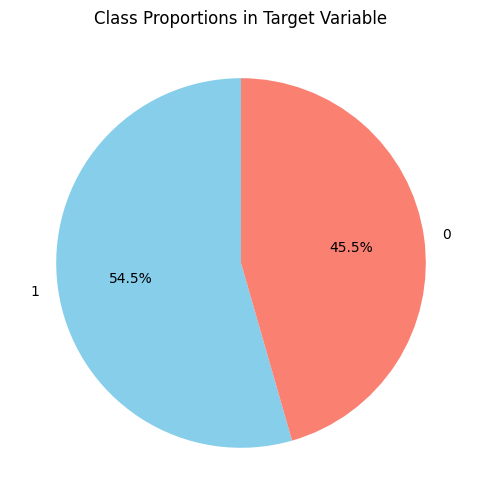

In [158]:
plt.figure(figsize=(6, 6))
plt.pie(targetpercentage.values, labels=targetpercentage.index, autopct='%1.1f%%', 
        colors=['skyblue', 'salmon'], startangle=90)
plt.title('Class Proportions in Target Variable')
plt.show()

In [159]:
#handle any missing values
print("Missing values per column:\n", df.isnull().sum())  # Counts NaN per column
print("\nTotal missing:", df.isnull().sum().sum())
print("\nMissing percentage:\n", (df.isnull().sum() / len(df)) * 100)

Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Total missing: 0

Missing percentage:
 age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64


In [160]:
#one hot encoding
cat_variables = ['sex',
'cp',
'restecg',
'slope',
'ca',
'thal'
]

df = pd.get_dummies(data = df,
                         prefix = cat_variables,
                         columns = cat_variables,dtype=int)

df.head()

,age,trestbps,chol,fbs,thalach,exang,oldpeak,target,sex_0,sex_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,63,145,233,1,150,0,2.3,1,0,1,...,0,1,0,0,0,0,0,1,0,0
1,37,130,250,0,187,0,3.5,1,0,1,...,0,1,0,0,0,0,0,0,1,0
2,41,130,204,0,172,0,1.4,1,1,0,...,1,1,0,0,0,0,0,0,1,0
3,56,120,236,0,178,0,0.8,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,57,120,354,0,163,1,0.6,1,1,0,...,1,1,0,0,0,0,0,0,1,0


In [161]:
features = [x for x in df.columns if x not in 'target'] #removing the target variable
print(len(features))

28


In [162]:
#Splitting the data-set
x_train, x_val, y_train, y_val = train_test_split(df[features], df['target'], train_size = 0.8, random_state = RANDOM_STATE)

print(f'train samples: {len(x_train)}')
print(f'validation samples: {len(x_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')


train samples: 242
validation samples: 61
target proportion: 0.5331


Logistic Regression ( Baseline model)

In [163]:
model = LogisticRegression(random_state=RANDOM_STATE , max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.3f}") #0-1 range
print(f"Accuracy: {accuracy_score(y_val, y_pred)*100:.3f}") #percentage representation

Accuracy: 0.820
Accuracy: 81.967


C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BUILD MODELS

1.RANDOM FOREST

In [164]:
#train the model 
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_model.fit(x_train, y_train)

print("Model trained !")

Model trained !


In [165]:
#evaluate
#prediction & probabilities
y_pred = rf_model.predict(x_val)
y_pred_proba = rf_model.predict_proba(x_val)[:, 1]
#accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"1.Accuracy: {accuracy:.3f}")
#precision,recall,f1-score
print("\n2.Classification Report:")
print(classification_report(y_val, y_pred))
#auc-roc
auc = roc_auc_score(y_val, y_pred_proba)
print(f"3.AUC-ROC: {auc:.3f}")

1.Accuracy: 0.770

2.Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        25
           1       0.79      0.83      0.81        36

    accuracy                           0.77        61
   macro avg       0.76      0.76      0.76        61
weighted avg       0.77      0.77      0.77        61

3.AUC-ROC: 0.897


2.XGBOOST

In [166]:
#train the model
xgb_model = XGBClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    eval_metric='logloss'  # For binary classification
)
xgb_model.fit(x_train, y_train)

print("Model trained !")


Model trained !


In [167]:
#evaluate
#prediction & probabilities
y_pred = xgb_model.predict(x_val)
y_pred_proba = xgb_model.predict_proba(x_val)[:, 1]
# accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"1.Accuracy: {accuracy:.3f}")
# precision ,recall ,f1-score
print("\n2.Classification Report:")
print(classification_report(y_val, y_pred))
#auc-roc
auc = roc_auc_score(y_val, y_pred_proba)
print(f"AUC-ROC: {auc:.3f}")

1.Accuracy: 0.721

2.Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.56      0.62        25
           1       0.73      0.83      0.78        36

    accuracy                           0.72        61
   macro avg       0.72      0.70      0.70        61
weighted avg       0.72      0.72      0.71        61

AUC-ROC: 0.810


As it concluded that accuracy is higher in random forest algorithm
Accuracy(random forest = .787)
Accuracy(XGBOOST = .721)

In [168]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'] # or integers [1, 3, 5]
}


In [169]:
rf_grid = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
grid_search = GridSearchCV(rf_grid, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(x_train, y_train)
# Best Model
best_rf = grid_search.best_estimator_
print(f"\nBest Parameters (GridSearch): {grid_search.best_params_}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.3f}")
# Evaluate on Val Set
y_pred_tuned = best_rf.predict(x_val)
y_proba_tuned = best_rf.predict_proba(x_val)[:, 1]
acc_tuned = accuracy_score(y_val, y_pred_tuned)
auc_tuned = roc_auc_score(y_val, y_proba_tuned)
print(f"Tuned Random Forest:")
print(f"Accuracy: {acc_tuned:.3f} ({acc_tuned * 100:.1f}%)")
print(f"ROC-AUC: {auc_tuned:.3f}")
print("\n Classification Report:\n", classification_report(y_val, y_pred_tuned))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best Parameters (GridSearch): {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best CV ROC-AUC: 0.917
Tuned Random Forest:
Accuracy: 0.803 (80.3%)
ROC-AUC: 0.888

 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75        25
           1       0.82      0.86      0.84        36

    accuracy                           0.80        61
   macro avg       0.80      0.79      0.79        61
weighted avg       0.80      0.80      0.80        61



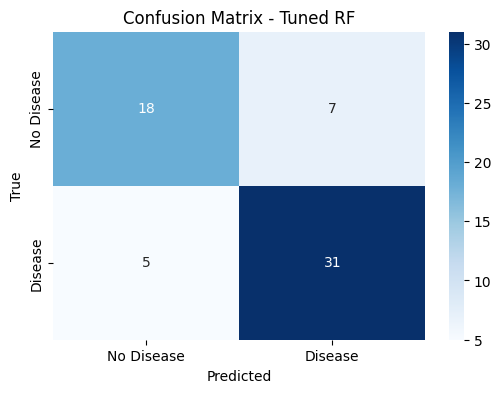

In [170]:

cm = confusion_matrix(y_val,y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Tuned RF')
plt.ylabel('True'), plt.xlabel('Predicted')
plt.show()


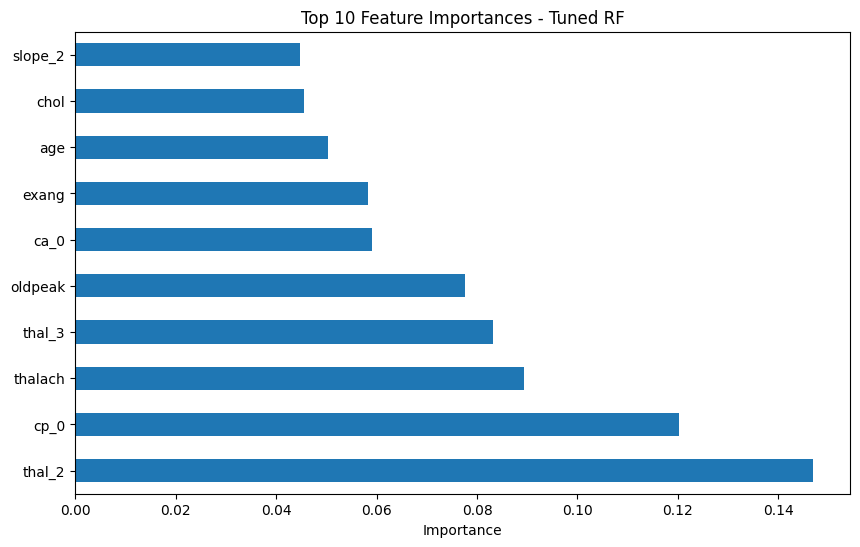

In [171]:
importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances - Tuned RF')
plt.xlabel('Importance')
plt.show()
